In [5]:
# Load data
import torchvision
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50

excel_file_path = '/kaggle/input/hodaya-sasson/ExcelOdd.xlsx'
df = pd.read_excel(excel_file_path)

# Outlier removal
df['Z-Score'] = zscore(df['Proj Qty'])
df = df.loc[df['Z-Score'].abs()<=3.8]

style_column = df['Style']
proj_qty_column = df['Proj Qty']
folder_path = '/kaggle/input/hodaya-sasson/Odd'
gif_files = [file for file in os.listdir(folder_path) if file.lower().endswith('.gif')]



data = []

for gif_file in gif_files:
    style_name = gif_file[:-4]
    if style_name in style_column.values:
        index = style_column[style_column == style_name].index[0]
        proj_qty = proj_qty_column[index]
        data.append({'Style': style_name, 'Filename': gif_file, 'Proj Qty': proj_qty})

structured_data = pd.DataFrame(data)

IMAGE_SIZE = (224, 224)
X = []
y = []

for _, row in structured_data.iterrows():
    image_path = os.path.join(folder_path, row['Filename'])
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(IMAGE_SIZE)
        image_array = np.array(image)
        image_array = image_array / 255.0
        X.append(image_array)
        y.append(row['Proj Qty'])
    except Exception as e:
        print(f"Error processing image '{image_path}': {str(e)}")

X = np.array(X)
y = np.array(y)

y_min = np.min(y)
y_max = np.max(y)
y = (y - y_min) / (y_max - y_min)

#     Training Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

X_augmented = []
y_augmented = []

for x, y in zip(X, y):
    x = x.reshape((1,) + x.shape)
    for x_aug in datagen.flow(x, batch_size=1):
        X_augmented.append(x_aug[0])
        y_augmented.append(y)
        if len(X_augmented) % 100 == 0:
            print(f"Generated {len(X_augmented)} augmented images so far...")
        break

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"X_augmented shape: {X_augmented.shape}")
print(f"y_augmented shape: {y_augmented.shape}")

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.labels is not None:
            label = self.labels[idx]
        else:
            label = None
        if self.transform:
            try:
                image = Image.fromarray((image * 255).astype(np.uint8), 'RGB')
                image = self.transform(image)
            except Exception as e:
                print("Failed to transform image. Error: ", str(e))
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_augmented, y_augmented, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


resnet = models.resnet18(pretrained=True)
# resnet = torchvision.models.resnet50(pretrained=True)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
ct = 0
for child in resnet.children():
    ct += 1
    if ct > len(list(resnet.children())) - 4:
#     if ct > len(list(resnet.children())) - 20:

        for param in child.parameters():
            param.requires_grad = True

# Modify the architecture to make it slightly simpler with a dropout layer
num_features = resnet.fc.in_features
# VVVvVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVv
#     resnet.fc = nn.Sequential(
#         nn.Linear(num_features, 512),
#         nn.ReLU(),

#         nn.Dropout(0.6),
#         nn.Linear(512, 1)
#     )
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
resnet.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)





# Define Loss, L1 and L2 regularization strengths, and Optimizer
criterion = nn.MSELoss()
l1_lambda = 0.00000015

l2_lambda = 0.0015


optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.0001, weight_decay=l2_lambda)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR every 10 epochs by 10%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Training Loop

num_epochs = 150
train_losses = []
all_labels = []
all_predictions = []
r2_scores = []

for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0.0
    predictions = []
    labels_list = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = resnet(images)

        # Add L1 regularization
        l1_norm = sum(p.abs().sum() for p in resnet.parameters())
        loss = criterion(outputs.view(-1), labels) + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        # Store predictions for this batch
        predictions.extend(outputs.view(-1).detach().cpu().numpy())
        labels_list.extend(labels.view(-1).detach().cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Calculate and store R^2 score for this epoch
    r2 = r2_score(labels_list, predictions)
    r2_scores.append(r2)

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, R2 Score: {r2:.4f}')

    all_predictions.append(predictions)
    all_labels.append(labels_list)

Generated 100 augmented images so far...
Generated 200 augmented images so far...
Generated 300 augmented images so far...
X_augmented shape: (395, 224, 224, 3)
y_augmented shape: (395,)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/150, Train Loss: 0.1929, R2 Score: -3.9977
Epoch: 2/150, Train Loss: 0.1545, R2 Score: -2.8501
Epoch: 3/150, Train Loss: 0.1157, R2 Score: -1.6905
Epoch: 4/150, Train Loss: 0.1000, R2 Score: -1.2232
Epoch: 5/150, Train Loss: 0.0805, R2 Score: -0.6404
Epoch: 6/150, Train Loss: 0.0756, R2 Score: -0.4970
Epoch: 7/150, Train Loss: 0.0606, R2 Score: -0.0516
Epoch: 8/150, Train Loss: 0.0552, R2 Score: 0.1074
Epoch: 9/150, Train Loss: 0.0517, R2 Score: 0.2106
Epoch: 10/150, Train Loss: 0.0513, R2 Score: 0.2188
Epoch: 11/150, Train Loss: 0.0497, R2 Score: 0.2642
Epoch: 12/150, Train Loss: 0.0427, R2 Score: 0.4683
Epoch: 13/150, Train Loss: 0.0403, R2 Score: 0.5380
Epoch: 14/150, Train Loss: 0.0393, R2 Score: 0.5641
Epoch: 15/150, Train Loss: 0.0391, R2 Score: 0.5642
Epoch: 16/150, Train Loss: 0.0372, R2 Score: 0.6179
Epoch: 17/150, Train Loss: 0.0364, R2 Score: 0.6385
Epoch: 18/150, Train Loss: 0.0345, R2 Score: 0.6902
Epoch: 19/150, Train Loss: 0.0342, R2 Score: 0.6942
Epoch: 20/150,

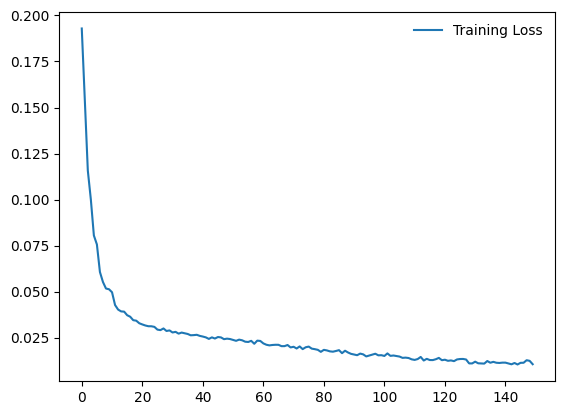

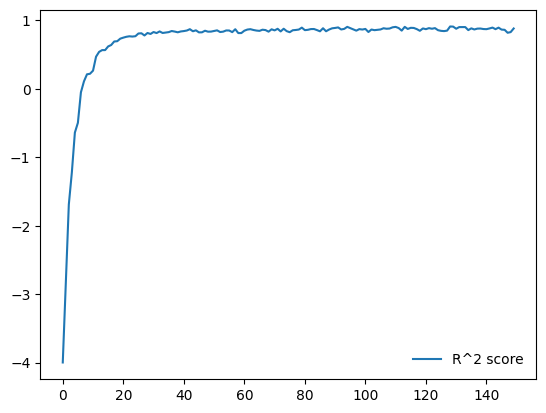

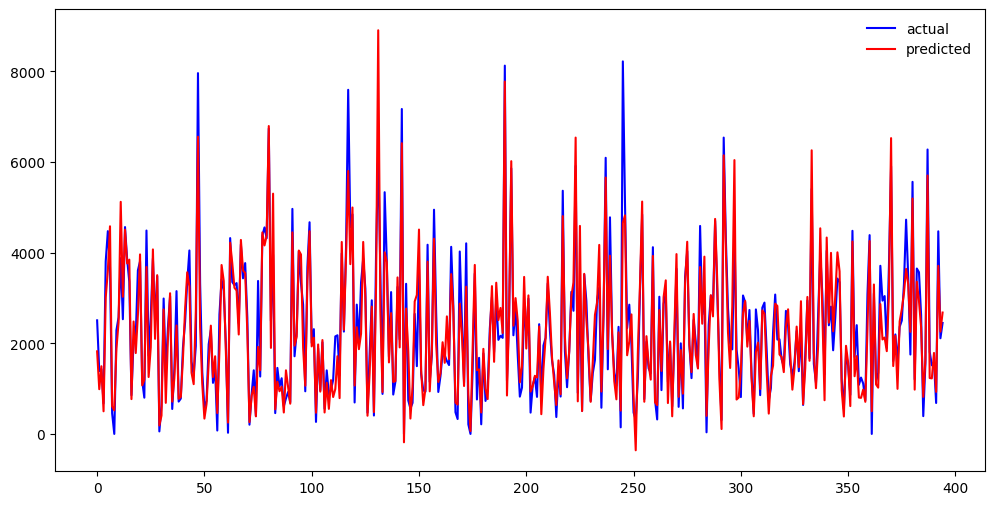

Best R^2 Score: 0.9092956820549787 occurred at epoch 129


In [6]:
all_predictions_denorm = [[y_min + pred * (y_max - y_min) for pred in sublist] for sublist in all_predictions]
all_labels_denorm = [[y_min + label * (y_max - y_min) for label in sublist] for sublist in all_labels]

# Plotting the loss
plt.plot(train_losses, label='Training Loss')
plt.legend(frameon=False)
plt.show()

# Plotting R^2 scores
plt.plot(r2_scores, label='R^2 score')
plt.legend(frameon=False)
plt.show()

# Plotting actual vs predicted labels
# Plotting actual vs predicted labels for the last epoch
plt.figure(figsize=(12,6))
plt.plot(all_labels_denorm[-1], 'b-', label='actual')
plt.plot(all_predictions_denorm[-1], 'r-', label='predicted')
plt.legend(frameon=False)
plt.show()

best_r2_score = max(r2_scores)
best_epoch = r2_scores.index(best_r2_score) + 1

print(f'Best R^2 Score: {best_r2_score} occurred at epoch {best_epoch}')


# **predict data**

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset

# Load the dataset and exclude outliers using Z-Score
excel_file_path_predict = '/kaggle/input/killll/ExcelHalfEven (1).xlsx'
df_predict = pd.read_excel(excel_file_path_predict)

# Calculate Z-Score for 'Proj Qty' column
df_predict['Z-Score'] = zscore(df_predict['Proj Qty'])
# Exclude outliers
df_predict = df_predict[df_predict['Z-Score'].abs() <= 4]

# Proceed with the prediction data preparation
style_column_predict = df_predict['Style']
proj_qty_column_predict = df_predict['Proj Qty']

folder_path_predict = '/kaggle/input/dbdbdbdbdbdbdbdbdbdbdbd/Even'
gif_files_predict = [file for file in os.listdir(folder_path_predict) if file.lower().endswith('.gif')]

data_predict = []
for gif_file in gif_files_predict:
    style_name = gif_file[:-4]
    if style_name in style_column_predict.values:
        index = style_column_predict[style_column_predict == style_name].index[0]
        proj_qty = proj_qty_column_predict[index]
        data_predict.append({'Style': style_name, 'Filename': gif_file, 'Proj Qty': proj_qty})

structured_data_predict = pd.DataFrame(data_predict)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[index]
        if image is None:
            return None
        if self.transform:
            image = self.transform(image)
        # Permute the tensor dimensions
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        return image

# Custom Collate Function
def custom_collate(batch):
    # Filter out None samples from the batch
    valid_samples = [data for data in batch if data is not None]
    
    # If there are no valid samples, return None
    if len(valid_samples) == 0:
        return None
    
    # Use the default collate for the valid samples
    return torch.utils.data.dataloader.default_collate(valid_samples)

# Process Images
X_predict = []
for _, row in structured_data_predict.iterrows():
    image_path = os.path.join(folder_path_predict, row['Filename'])
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((224, 224))  # Assuming a standard size; modify if you have a different size
        image_array = np.array(image)
        image_array = image_array / 255.0
        X_predict.append(image_array)
    except Exception as e:
        print(f"Error processing image '{image_path}': {str(e)}")

X_predict = np.array(X_predict)
predict_dataset = CustomDataset(X_predict)  # add transform if you have any
predict_loader = DataLoader(predict_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

# Predict using the model (assuming you've defined `resnet` and `device` elsewhere in your code)
resnet.eval()  
predictions = []

with torch.no_grad():
    for images in predict_loader:
        if images is None:  # Skip if there's no valid data in the batch
            continue
        images = images.to(device)
        outputs = resnet(images)
        predictions.extend(outputs.view(-1).cpu().numpy())


In [1]:

# Convert predictions to a NumPy array
predictions_array = np.array(predictions)

# Denormalize the predicted and actual values
predictions_denorm = y_min + predictions_array * (y_max - y_min)
actual_values_denorm = np.array(df_predict['Proj Qty'])

# Calculate the absolute differences for denormalized values
abs_diff_denorm = np.abs(predictions_denorm - actual_values_denorm)

# Count the number of differences no greater than 500
count_diff_leq_500 = np.sum(abs_diff_denorm <= 500)

# Calculate the percentage of such forecasts
total_predictions = len(predictions_array)
percentage_good_forecasts = (count_diff_leq_500 / total_predictions) * 100

print(f"Number of predictions where the maximum difference is no more than 500: {count_diff_leq_500}")
print(f"Percentage of good forecasts: {percentage_good_forecasts}%")